# Data import & data processing

Data Sources : 
    MSCI EURO, Inflation EUROZONE, EUROZONE GDP / FACTSET
    MRO : EUROSTAT 
    Statements : ECB Website

In [8]:

import pandas as pd
import re
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
import itertools
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Web scrapping

In this Python script, we use Selenium to control an automated Chrome browser, directing it to the ECB website. We wait briefly to let the page load completely. Then, we employ BeautifulSoup to parse the page's content, focusing on specific HTML tags that hold dates and links to statements. We loop through these elements, extracting the necessary information. For each statement, we use Selenium again to open its link and extract the main content. After gathering all the data, we close the automated browser and organize the collected information into a structured table using pandas, making the data easier to handle and analyze.

In [3]:

# Set up the WebDriver
driver = webdriver.Chrome()

# The target URL
url = 'https://www.ecb.europa.eu/press/pressconf/html/index.en.html'

# Open the page with Selenium
driver.get(url)

# Let the page load (wait for a few seconds if needed)
time.sleep(3)

# Get the page source and parse it with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Find all <dt> and <dd> tags which contain the date and the link respectively
dates = soup.find_all('dt', {'isodate': True})
statements = soup.find_all('dd')

# Initialize an empty list to store the data
data = []

# Iterate over the dates and statements
for date, statement in zip(dates, statements):
    # Extract date
    statement_date = date.div.text.strip()

    # Extract the link
    link_tag = statement.find('a')
    if link_tag and 'href' in link_tag.attrs:
        statement_url = 'https://www.ecb.europa.eu' + link_tag['href']

        # Use Selenium to open the statement page
        driver.get(statement_url)
        time.sleep(3)  # Wait for the page to load

        # Parse the opened page
        statement_soup = BeautifulSoup(driver.page_source, 'html.parser')
        # Extract content from the <main> tag
        statement_content = statement_soup.find('main').text.strip() if statement_soup.find('main') else ''

        # Append the data to the list
        data.append({
            'date': statement_date,
            'link': statement_url,
            'content': statement_content
        })

# Close the WebDriver
driver.quit()

# Create a DataFrame
df = pd.DataFrame(data)

# Now df contains the desired data
df.to_csv('final_df.csv')


KeyboardInterrupt: 

# Data processing

Instead of reloading the scrapper, use the dataset that was already scrapped!

In [10]:

# Load the dataset
ecb_statements = pd.read_csv('final_df.csv').drop('Date',axis=1)

#ecb_statements['date'] = pd.to_datetime(ecb_statements['date'], format='%d %B %Y')

# The 'date' column will now be in the numeric date format (yyyy-mm-dd)
# Display the DataFrame to verify
ecb_statements.head()
df_conf=ecb_statements
df_conf
df_conf['date']=pd.to_datetime(df_conf['date'],format='%Y-%m-%d')

 # Content cleaning
 

In this script, we're refining our DataFrame, `df_conf`, which contains data like dates and text content. First, we remove any occurrences of the phrase "Jump to the transcript" from the 'content' column. Next, we apply a custom function, `text_cleansing`, to each row in the 'content' column. This function searches for the word "answers" and trims the text from that point, removing any following predefined phrases. Then, we set the 'date' column as the DataFrame's index, giving a time-based structure to our data. Optionally, we could also remove entries that lack meaningful text content, ensuring our DataFrame contains only relevant data.

In [12]:

# 1. Remove "Jump to the transcript" phrases
df_conf['content'] = df_conf['content'].str.replace("Jump to the transcript", "", regex=False)

# 2. Apply the text_cleansing function to each row in the 'content' column
def text_cleansing(text):
    index = text.find("answers")
    if index != -1:
        text_cleaned = text[index + len("answers"):].strip()
        split_phrases = [
            "We are now ready to take your questions.",
            "We are now at your disposal for questions.",
            "We are now at your disposal, should you have any questions.",
            "Transcript of the questions asked and the answers given by",
            "We stand ready to answer any questions you may have.",
            "CONTACT",
            "You may also be interested",
            "Related topics"
        ]
        for phrase in split_phrases:
            text_cleaned = text_cleaned.split(phrase)[0]
        return text_cleaned
    else:
        return text

df_conf['content'] = df_conf['content'].apply(text_cleansing)

# 3. Set the 'date' column as the index of the DataFrame
df_conf = df_conf.set_index('date')

# Additional operation (if required):
# Drop an entry without text content (if applicable)
# df_conf = df_conf.drop(index=[index_of_unnecessary_entry])


KeyError: "None of ['date'] are in the columns"

In this code, we first create a list of English stopwords. We then define a function, `clean`, to preprocess text: converting it to lowercase, removing punctuation, tokenizing into words, and excluding stopwords. We apply this function to the 'content' column of our DataFrame, `df_conf`, creating a new 'transform' column with the cleaned text. Finally, we use the PorterStemmer to stem the words in the 'transform' column, storing the stemmed words in a new column, 'stem', in our DataFrame.

In [13]:

stops = list(stopwords.words('english'))


def clean(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = word_tokenize(x)
    x = [w for w in x if w not in stops]
    return(x)

df_conf['transform'] = [clean(i) for i in (df_conf['content'])]

stemmer = PorterStemmer()
df_conf['stem'] = df_conf['transform'].apply(lambda x: [stemmer.stem(token) for token in x])
df_conf

,Unnamed: 0,link,content,transform,stem
date,,,,,
2023-10-26,0,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-09-14,1,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-07-27,2,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-23,3,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-04,4,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
...,...,...,...,...,...
1998-11-03,270,https://www.ecb.europa.eu/press/pressconf/1998...,.,[],[]
1998-10-13,271,https://www.ecb.europa.eu/press/pressconf/1998...,.\r\n\r\n\r\n\r\n\r\n\r\nTranscript of the Que...,"[transcript, questions, answers, dr, willem, f...","[transcript, question, answer, dr, willem, f, ..."
1998-09-01,272,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\r...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ..."


# SIMILARITY MEASURE

This code block in Python begins by sorting a DataFrame, `df_conf`, based on dates. It then defines two functions: `jaccard_similarity`, which calculates the Jaccard similarity between two sets (a measure of overlap), and `find_bigrams`, which creates bigrams (pairs of adjacent elements) from a list. The script calculates the Jaccard similarity of bigrams for successive entries in the 'stem' column of `df_conf`. These similarity scores are stored in a new column, 'jaccard_similarity'. Finally, it visualizes these similarities over time using a plot, providing insights into the changes in speech patterns or topics.

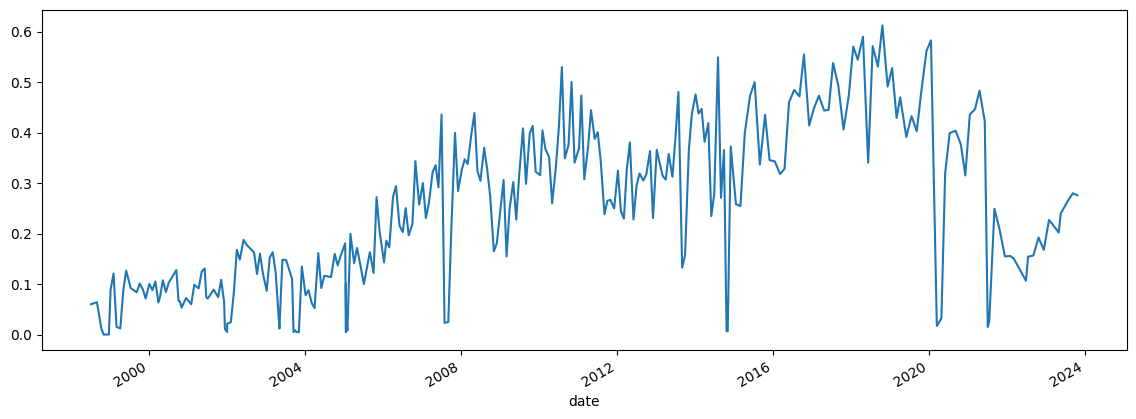

In [14]:
import pandas as pd
import numpy as np
from itertools import tee, islice
df_conf=df_conf.sort_values(by='date')
def jaccard_similarity(set_1, set_2):
    intersection = set_1.intersection(set_2)
    union = set_1.union(set_2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def find_bigrams(input_list):
    a, b = tee(input_list)
    next(b, None)
    return set(zip(a, b))

jaccard_similarities = [np.nan]  # 

# Iterate over the DataFrame and calculate Jaccard similarity for bigrams of successive speeches
for i in range(1, len(df_conf['stem'])):
    bigrams_i = find_bigrams(df_conf['stem'].iloc[i])
    bigrams_i_1 = find_bigrams(df_conf['stem'].iloc[i - 1])
    similarity = jaccard_similarity(bigrams_i, bigrams_i_1)
    jaccard_similarities.append(similarity)

# Add the similarity scores to the DataFrame
df_conf['jaccard_similarity'] = jaccard_similarities
plt.figure(figsize=(14,5))
df_conf.jaccard_similarity.plot()
plt.show()

# Pessimism Score


In [15]:
df_conf=df_conf.drop('Unnamed: 0',axis=1)


This Python script extends df_conf, a DataFrame, by adding columns to assess pessimism in its text. It loads the Loughran-McDonald sentiment word lists, extracting negative and positive words. The calculate_pessimism function computes two pessimism scores for each row, considering the balance of negative and positive words. These scores are then added to df_conf. The first score is a relative measure (balance of negative and positive words), and the second is a ratio of negative words to the total word count.

In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm


df_conf['pessimism'] = np.nan
df_conf['pessimism_2'] = np.nan

# Load the Loughran-McDonald sentiment word lists
lm = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')
neg_list = set(lm[lm["Negative"] != 0]["Word"].str.lower())
pos_list = set(lm[lm["Positive"] != 0]["Word"].str.lower())

# Function to calculate pessimism
def calculate_pessimism(row):
    neg_words = [token for token in row['transform'] if token in neg_list]
    pos_words = [token for token in row['transform'] if token in pos_list]
    
    neg_count = len(neg_words)
    pos_count = len(pos_words)
    total_words = len(row['transform'])

    # Avoid division by zero
    if total_words == 0:
        return np.nan, np.nan

    pessimism_score = (neg_count - pos_count) / (neg_count + pos_count + 1e-10)
    pessimism_score_2 = (neg_count - pos_count) / total_words

    return pessimism_score, pessimism_score_2

# Apply the function to the DataFrame
pessimism_scores = df_conf.apply(calculate_pessimism, axis=1)
df_conf['pessimism'] = [score[0] for score in pessimism_scores]
df_conf['pessimism_2'] = [score[1] for score in pessimism_scores]


In [18]:
df_conf=df_conf.reset_index()

# Plotting


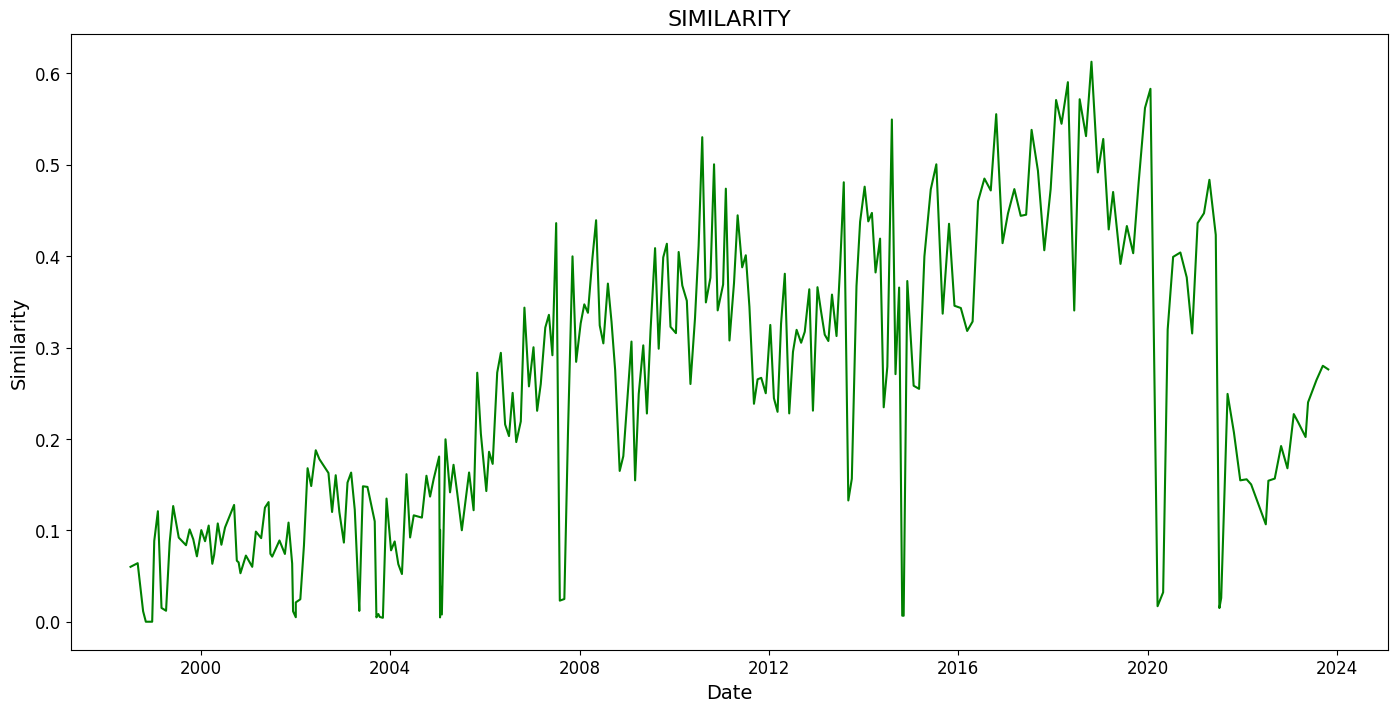

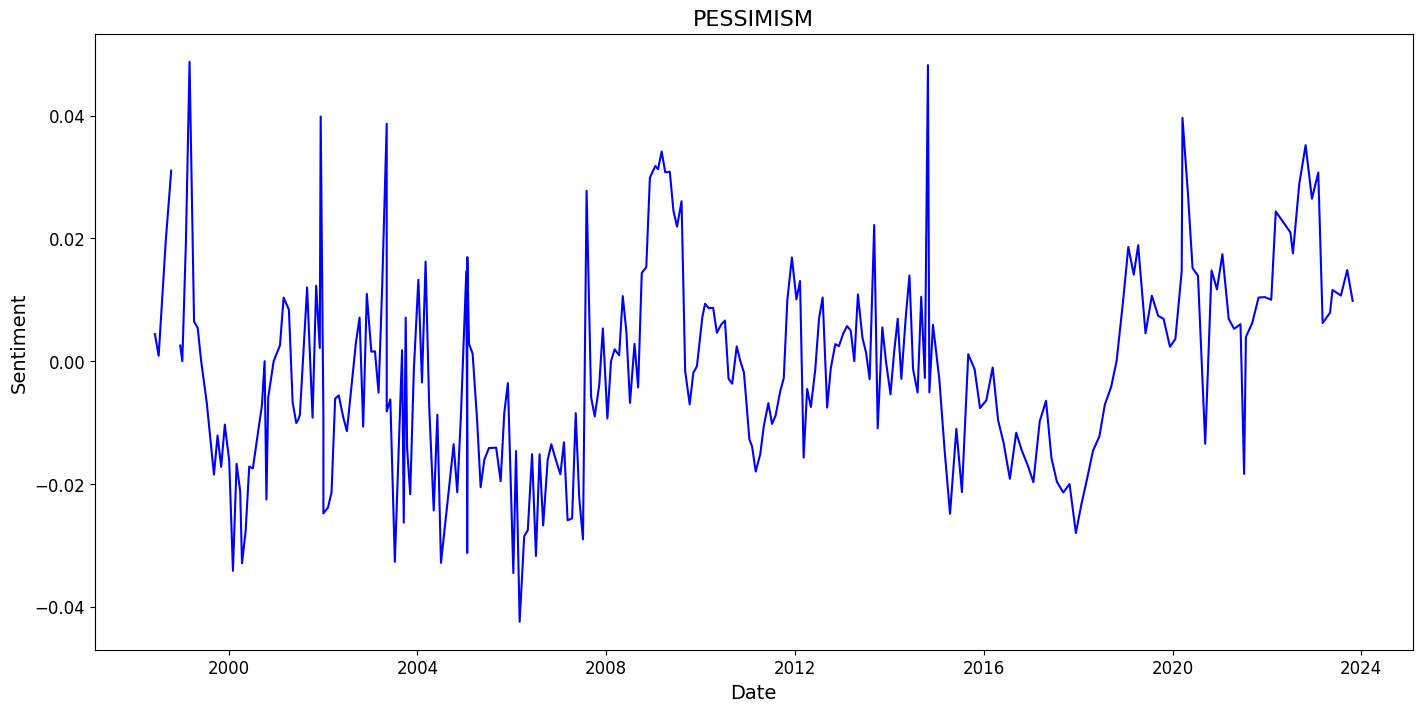

In [19]:
# plotting function to be applied to every measure
df_conf.rename(columns={'date': 'Date'}, inplace=True)
def plot_result(df, x, y, title, xlabel, ylabel, color):
    # Create a figure and set the size
    plt.figure(figsize=(17, 8))

    # Plot the specified columns using the specified color
    plt.plot(df[x], df[y], color=color)

    # Add a title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid()

    # Show the plot
    plt.show()


# Convert 'date' column to datetime format in date_2 just for visualisation
df_conf['date_2'] = pd.to_datetime(df_conf['Date'])


#plot  similarity
plot_result(df_conf, 'date_2', 'jaccard_similarity', 'SIMILARITY', 'Date', 'Similarity', 'green')
# plot sentiment_2 which the one used in the paper
plot_result(df_conf, 'date_2', 'pessimism_2', 'PESSIMISM', 'Date', 'Sentiment', 'blue')
#plot pessimism 1
#plot_result(df_conf, 'date_2', 'pessimism', 'PESSIMISM', 'Date', 'Sentiment', 'teal')


This Python code snippet calculates the number of days that have passed since June 9, 1998, for each date in the `df_conf` DataFrame. It defines a function, `days_since_1998`, which takes a date and returns the difference in days from the specified start date. The function is then applied to a column named 'date_2' in `df_conf`, and the results are stored in a new column 'diff'.

After calculating these differences, the script creates a new DataFrame, `reg_df`, by selecting certain columns from `df_conf`: 'Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', and 'diff'. The 'date' column is renamed to 'Date' for consistency. `reg_df` is then displayed,  for visualization. This setup is typically used in preparation for regression analysis or other statistical modeling.

In [20]:
from datetime import datetime

def days_since_1998(date):
    start_date = datetime(1998, 6, 9)
    end_date = date
    return (end_date - start_date).days


dt = [days_since_1998(i) for i in df_conf['date_2']]
df_conf['diff'] = dt


reg_df = df_conf[['Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', 'diff']]
reg_df = reg_df.rename(columns={'date': 'Date'})

reg_df

,Date,jaccard_similarity,pessimism,pessimism_2,diff
0,1998-06-09,NaN,1.000000,0.004425,0
1,1998-07-08,0.060071,0.040000,0.000881,29
2,1998-09-01,0.064062,0.531915,0.019592,84
3,1998-10-13,0.011471,0.474747,0.031044,126
4,1998-11-03,0.000000,NaN,NaN,147
...,...,...,...,...,...
270,2023-05-04,0.202136,0.148936,0.007910,9095
271,2023-05-23,0.240066,0.214286,0.011617,9114
272,2023-07-27,0.264469,0.227273,0.010695,9179
273,2023-09-14,0.280069,0.291667,0.014846,9228


This Python script processes stock data from the 'MSCI EURO.xlsx' file. It loads and sorts the data by date, converts the 'Date' column to a datetime format, and calculates the natural logarithm of the 'Price' column. It then computes the percentage change in this logarithmic price, which is a common financial metric for returns. After displaying the last 40 entries for review, the script drops any rows with missing values to clean the dataset. Finally, the percentage change column is converted to a NumPy array, likely for further numerical analysis or modeling. The cleaned and processed DataFrame, df_eurostock, is ready for use.

In [23]:
df_eurostock = pd.read_excel('MSCI EURO.xlsx')[['Date','Price']].sort_values(by='Date')
df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')
df_eurostock['last'] = list(map(lambda x: np.log(x), df_eurostock['Price']))
df_eurostock['pct_change'] = np.nan
df_eurostock['pct_change'] = df_eurostock['last'].diff(1)


In [24]:
df_eurostock.tail(40)
df_eurostock.dropna(inplace=True)
df_eurostock_to_np = df_eurostock['pct_change'].to_numpy()
df_eurostock

,Date,Price,last,pct_change
7011,1997-01-01,549.766000,6.309493,0.000000
7010,1997-01-02,540.659000,6.292789,-0.016704
7009,1997-01-03,545.842000,6.302330,0.009541
7008,1997-01-06,549.316000,6.308674,0.006344
7007,1997-01-07,549.231000,6.308519,-0.000155
...,...,...,...,...
4,2023-11-10,1371.655134,7.223773,-0.007365
3,2023-11-13,1381.763593,7.231116,0.007343
2,2023-11-14,1402.400629,7.245941,0.014825
1,2023-11-15,1409.783286,7.251191,0.005250


# GETTING EUROSTOCK DATA

In our script, we process financial data from `df_eurostock` to calculate abnormal returns and cumulative abnormal returns (CAR). We start by initializing dictionaries and NaN columns for cumulative and CAR values. We then calculate a moving average of percentage changes in stock prices over 201 days and assign these values to the 'cumulate' column. Abnormal returns are computed by subtracting this average from the daily percentage change. Similarly, we calculate CAR by summing abnormal returns over an 11-day window. We format the 'Date' column for consistency and rename columns for clarity. Finally, we create `df_eurostock_final`, a new DataFrame containing dates, cumulative values, abnormal returns, and CAR, focused on analyzing Eurostock's performance.

In [26]:



window_value_abnormal_return = {}
window_value_car = {}

df_eurostock['cumulate'] = np.nan
df_eurostock['CAR'] = np.nan

 
for n in (range(len(df_eurostock_to_np))):
    x = df_eurostock_to_np[n-251:n-50]
    window_value_abnormal_return[n] = 1/201*(np.sum(x))
liste_cumu = list(window_value_abnormal_return.values())
df_eurostock.cumulate = liste_cumu
df_eurostock['abnormal_return'] = np.nan

 
df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - df_eurostock['cumulate']
df_eurostock_car_to_np = df_eurostock['abnormal_return'].to_numpy()

#  Computation of cumulative abnormal returns via the same method used above
for n in (range(len(df_eurostock_car_to_np))):
    x = df_eurostock_car_to_np[n-6:n+5]
    window_value_car[n] = np.sum(x)
liste_car= list(window_value_car.values())
df_eurostock.CAR = liste_car

df_eurostock['Date'] = df_eurostock['Date'].astype('datetime64[ns]')
df_eurostock.rename(columns = {'last':'eurostock_last','pct_change':'eurostock_pct_change','cumulate':'eurostock_cumulate',
                               'abnormal_return':'eurostock_abnormal_return', 'CAR':'eurostock_CAR'}, inplace = True)

df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# retrieving Eurostock CAR results in a new df
df_eurostock_final = df_eurostock.loc[:,['Date', 'eurostock_cumulate', 'eurostock_abnormal_return', 'eurostock_CAR']]
df_eurostock_final

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR
7011,1997-01-01,0.000309,-0.000309,0.000000
7010,1997-01-02,0.000297,-0.017001,0.000000
7009,1997-01-03,0.000323,0.009218,0.000000
7008,1997-01-06,0.000333,0.006011,0.000000
7007,1997-01-07,0.000338,-0.000493,0.000000
...,...,...,...,...
4,2023-11-10,0.000421,-0.007787,0.044410
3,2023-11-13,0.000381,0.006962,0.026850
2,2023-11-14,0.000370,0.014455,0.024388
1,2023-11-15,0.000392,0.004858,0.029241


In our script, we load and process inflation data from an Excel file named 'Inflation & interest.xlsx' into a DataFrame, `df_hicp`. We rename an unnamed column to 'Date' and select only the 'Date' and 'Inflation' columns, sorting them by date. After displaying the first few rows for a preview, we convert the 'Date' column to a datetime format, initially in the format of year-month. We then modify each date to include the first day of the month, ensuring a consistent date format across the DataFrame. Finally, we change the 'Date' column type to datetime for further analysis or merging with other time-series data.

In [27]:
df_hicp = pd.read_excel('Inflation & interest.xlsx')
df_hicp = df_hicp.rename(columns={'Unnamed: 0':'Date'})
df_hicp=df_hicp[['Date','Inflation']].sort_values(by='Date')
df_hicp.head()
df_hicp['Date'] = pd.to_datetime(df_hicp['Date'], format='%m/%Y').dt.strftime('%Y-%m')
df_hicp.Date = df_hicp.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_hicp['Date'] = df_hicp['Date'].astype('datetime64[ns]')

In [28]:
df_hicp=df_hicp.sort_values(by='Date')
df_hicp

,Date,Inflation
99,1998-12-01,1.358338
98,1999-03-01,0.761581
97,1999-06-01,0.971927
96,1999-09-01,1.167831
95,1999-12-01,1.646059
...,...,...
4,2022-09-01,9.447888
3,2022-12-01,10.058137
2,2023-03-01,8.936144
1,2023-06-01,6.913111


In our script, we analyze quarterly GDP data to understand economic trends. We start by loading the data from 'Q GDP LEVEL.xlsx' and converting the date format to reflect the start of each quarter. After setting dates as the index, we resample the GDP data to a daily frequency, interpolating values linearly for days within quarters.

Next, we fit a linear regression model to this daily interpolated data, using time as a feature to predict potential GDP. We then calculate the daily output gap, the difference between actual and potential GDP.

We create a DataFrame, `df_results`, to store the actual GDP, potential GDP, and output gap. For visualization, we plot these metrics, highlighting positive and negative output gaps. This analysis helps us understand the economic performance and potential deviations from expected trends.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
def parse_quarter(string):
    quarter, year = string.split('/')
    month = (int(quarter[1]) - 1) * 3 + 1  # Convert quarter to start month
    return f'{year}-{month:02d}-01'

# Load and preprocess the data
df_gdp_llevel = pd.read_excel('Q GDP LEVEL.xlsx')
df_gdp_llevel['Date'] = df_gdp_llevel['Date'].apply(parse_quarter)
df_gdp_llevel['Date'] = pd.to_datetime(df_gdp_llevel['Date'], format='%Y-%d-%m')
df_gdp_llevel = df_gdp_llevel.set_index('Date')
df_gdp_llevel_daily = df_gdp_llevel['GDPL'].resample('D').mean()
df_gdp_llevel_daily_interpolated = df_gdp_llevel_daily.interpolate(method='linear')

# Fit a linear model to the daily interpolated data
model = LinearRegression()
X = np.arange(len(df_gdp_llevel_daily_interpolated)).reshape(-1, 1)  # Time as a feature
y = df_gdp_llevel_daily_interpolated.values  # GDP values
model.fit(X, y)

# Predict potential GDP on the daily data
potential_gdp_daily = model.predict(X)

# Calculate daily output gap
output_gap_daily = y - potential_gdp_daily

# Create a DataFrame for the results
df_results = pd.DataFrame({
    'Actual GDP': df_gdp_llevel_daily_interpolated,
    'Potential GDP': potential_gdp_daily,
    'Output Gap': output_gap_daily
}, index=df_gdp_llevel_daily_interpolated.index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['Actual GDP'], label='Actual GDP')
plt.plot(df_results.index, df_results['Potential GDP'], label='Potential GDP', color='red')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] > df_results['Potential GDP']), 
                 color='green', alpha=0.3, label='Positive Output Gap')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] <= df_results['Potential GDP']), 
                 color='red', alpha=0.3, label='Negative Output Gap')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Actual vs Potential GDP and Output Gap (Daily Data)')
plt.legend()
plt.show()


ValueError: Unrecognized quarter format: 09/2023

In [31]:
df_gdp_llevel_daily_interpolated

Date
1998-01-04     5018.907700
1998-01-05     5018.907700
1998-01-06     5018.907700
1998-01-07     5018.907700
1998-01-08     5018.907700
                  ...     
2023-01-21    15098.451328
2023-01-22    15113.028394
2023-01-23    15127.605459
2023-01-24    15142.182525
2023-01-25    15156.759591
Freq: D, Name: GDPL, Length: 9153, dtype: float64

In [43]:
df_ogap_daily =df_results['Output Gap']


# Merging all datasets 

In our script, we convert monthly data from the 'Inflation & interest.xlsx' file to a daily frequency, focusing on the main refinancing operations (MRO) rate. We begin by loading the data and renaming an unnamed column to 'Date'. Then, we append a default day ('-01') to each date string to ensure a complete date format, and convert these strings to datetime objects.

After setting the 'Date' column as the DataFrame index, we resample the monthly data to daily frequency and interpolate the missing values to get a continuous daily dataset. This step is crucial for analyses requiring daily data granularity.

Finally, we convert the 'LTR INT RATE' column, which presumably represents the MRO rate, to a floating-point format, readying it for further financial analysis or merging with other datasets. The script prepares the data for detailed temporal analysis, allowing for more precise economic assessments.

In [32]:
 
## Convert monthly to daily for mro
from datetime import datetime
#import monthly and cleaning date columns
df_mro = pd.read_excel('Inflation & interest.xlsx')
df_mro = df_mro.rename(columns={'Unnamed: 0':'Date'})
# Convert the 'Date' column to a datetime format

# Append a default day to each date string and then convert to datetime
df_mro['Date'] = pd.to_datetime(df_mro['Date'].apply(lambda x: str(x) + '-01'), format='%m/%Y-%d')

# Set the 'Date' column as the index
df_mro = df_mro.set_index('Date')

# Resample and interpolate
df_mro_daily = df_mro.resample('D').mean()
df_mro_daily = df_mro_daily.interpolate()

# Reset the index and keep 'Date' as a column


df_mro['Rate'] = df_mro['LTR INT RATE'].astype(float)

#Interpolation to get daily MRO


In [33]:
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [44]:
df_ogap_daily=pd.DataFrame(df_ogap_daily, columns=[ 'Output Gap'])

In [45]:
df_ogap_daily=df_ogap_daily.reset_index()

In our script, we create a DataFrame containing a continuous range of dates from December 1, 1998, to October 26, 2023. We start by defining a function, `daterange`, that generates dates between two specified dates. Using this function, we iterate over each day within the given range, formatting each date as a string in the format "YYYY-MM-DD".

We collect these date strings in a list named `date_`. Next, we convert this list into a DataFrame, `df_date`, with a single column labeled 'Date'. Finally, we ensure that the 'Date' column in our DataFrame is in the correct datetime format, allowing for easy integration with other time-series data or subsequent temporal analyses. This DataFrame serves as a comprehensive timeline for further analysis or merging with other datasets.

In [37]:
## Create date column and convert it to dataframe
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

date_ = []
start_dt = date(1998, 12, 1)
end_dt = date(2023, 10, 26)
for dt in daterange(start_dt, end_dt):
    date_.append(dt.strftime("%Y-%m-%d"))
df_date = pd.DataFrame(date_, columns=['Date'])
df_date['Date'] = df_date['Date'].astype('datetime64[ns]')

In [38]:
df_mro_daily=df_mro_daily
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


We upload and process the refinancing rate data  

In [39]:
stri=pd.read_csv('ecb data.csv')
stri=stri.rename(columns={'DATE':'Date'})
stri['Date'] = pd.to_datetime(stri['Date'])
stri = stri.set_index('Date')
stri_daily = stri.resample('D').mean()
stri_daily = stri_daily.interpolate()


In [40]:
stri_daily['STR']=stri_daily['STR'].astype('float')

In our script, we integrate various financial and economic datasets into a comprehensive DataFrame. We start by merging a DataFrame of dates, `df_date`, with several other DataFrames: `df_eurostock_final`, `df_ogap_daily`, `df_mro_daily`, and another DataFrame related to statements (`df_conf`). This results in a merged DataFrame, `df_final_not_clean`.

We set 'Date' as the index and remove rows where all columns are NaN. We then interpolate missing values for key variables like Inflation, Output Gap, and the main refinancing operations (MRO) rate, ensuring a continuous daily dataset.

We drop rows missing crucial information (like 'link') and remove duplicates based on 'jaccard_similarity' and 'diff'. Additional computations include calculating the change in MRO rate and applying logarithmic transformations to the jaccard similarity and time difference variables.

Finally, we forward-fill remaining missing values for cumulative Eurostock metrics and filter the DataFrame to include only dates after December 31, 1998. The final DataFrame, `df_final_not_clean`, is a cleaned, merged, and interpolated dataset ready for in-depth financial and economic analysis.

In [46]:
import warnings
warnings.filterwarnings("ignore")

## join date col & reg_df
df_not_clean = pd.merge(df_date,df_eurostock_final,how='left',on=['Date'])
df_not_clean_2 = pd.merge(df_not_clean,df_ogap_daily,how='left',on=['Date'])
df_not_clean_3 = pd.merge(df_not_clean_2,df_mro_daily,how='left',on=['Date'])
df_not_clean_4=df_not_clean_3.merge(stri_daily, on='Date',how='left')
df_conf.rename(columns={'date':'Date'}, inplace=True)
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')

df_final_not_clean = pd.merge(df_not_clean_4,df_conf,how='left',on=['Date'])

df_final_not_clean.set_index('Date', inplace=True)
df_final_not_clean.dropna(axis = 0, how = 'all', inplace = True)
df_final_not_clean.reset_index(inplace=True)

# Interpolate our variables with a daily granularity
df_final_not_clean.HICP = df_final_not_clean['Inflation'].interpolate()
df_final_not_clean.output_gap = df_final_not_clean['Output Gap'].interpolate()
df_final_not_clean.mro = df_final_not_clean['STR'].interpolate()

df_final_not_clean.dropna(subset= ['link'], inplace=True)

#df_final_not_clean = df_final_not_clean [['Date','jaccard_similarity','pessimism','pessimism_2','eurostock_cumulate','eurostock_abnormal_return', 'eurostock_CAR', 'Inflation', 'Gdp growth', 'mro', 'diff']]
df_final_not_clean = df_final_not_clean [['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Output Gap', 'STR',

       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff']]
df_final_not_clean.drop_duplicates(subset=['jaccard_similarity','diff'], inplace=True)

#Calculating MRO returns
df_final_not_clean['change_MRO_Rate'] = df_final_not_clean['STR'].diff(1)

#Calculating log for similarity and for Time variable (log_diff)
df_final_not_clean['log_similarity'] = np.log(df_final_not_clean['jaccard_similarity'])
df_final_not_clean['log_diff'] = np.log(df_final_not_clean['diff'].values)

# filling in the remaining missing data w/ latest value
df_final_not_clean.eurostock_cumulate.ffill(inplace=True)
df_final_not_clean.eurostock_abnormal_return.ffill(inplace=True)
df_final_not_clean.eurostock_CAR.ffill(inplace=True)


df_final_not_clean.reset_index(inplace=True, drop=True)
df_final_not_clean = df_final_not_clean[df_final_not_clean.Date > '1998-12-31']
df_final_not_clean

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,Inflation,Output Gap,STR,jaccard_similarity,pessimism,pessimism_2,date_2,diff,change_MRO_Rate,log_similarity,log_diff
2,1999-01-07,0.000444,-0.016597,-0.025643,1.113005,-401.272150,3.000000,0.088464,0.000000,0.000000,1999-01-07,212.0,NaN,-2.425165,5.356586
3,1999-02-04,0.000563,-0.001802,-0.033480,0.927347,-450.037932,2.915584,0.120927,0.428571,0.019455,1999-02-04,240.0,-0.084416,-2.112569,5.480639
4,1999-03-04,0.000270,0.011865,-0.018795,0.768440,-527.071635,2.733766,0.015087,0.622047,0.048796,1999-03-04,268.0,-0.181818,-4.193907,5.590987
5,1999-04-08,-0.000043,0.000567,0.039784,0.848463,-623.363765,2.506494,0.012000,0.166667,0.006462,1999-04-08,303.0,-0.227273,-4.422849,5.713733
6,1999-05-06,0.000121,-0.003924,-0.017575,0.912481,-700.397469,2.564286,0.086957,0.142857,0.005445,1999-05-06,331.0,0.057792,-2.442347,5.802118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2023-05-04,0.000528,-0.005958,-0.020587,7.528816,NaN,3.719388,0.202136,0.148936,0.007910,2023-05-04,9095.0,0.386054,-1.598813,9.115480
266,2023-05-23,0.000301,-0.008916,-0.008130,7.111016,NaN,3.827381,0.240066,0.214286,0.011617,2023-05-23,9114.0,0.107993,-1.426840,9.117567
267,2023-07-27,0.000646,0.019623,-0.014460,5.998742,NaN,4.214286,0.264469,0.227273,0.010695,2023-07-27,9179.0,0.386905,-1.330030,9.124674
268,2023-09-14,0.001219,0.011422,-0.008933,NaN,NaN,4.469388,0.280069,0.291667,0.014846,2023-09-14,9228.0,0.255102,-1.272720,9.129998


In [ ]:
df_final_not_clean.isna().sum()

Date                         0
eurostock_cumulate           0
eurostock_abnormal_return    0
eurostock_CAR                0
Inflation                    2
Output Gap                   7
STR                          1
jaccard_similarity           0
pessimism                    0
pessimism_2                  0
date_2                       0
diff                         0
change_MRO_Rate              2
log_similarity               0
log_diff                     0
dtype: int64

In [79]:
df_final_not_clean.columns

Index(['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Output Gap', 'STR', 'jaccard_similarity',
       'pessimism', 'pessimism_2', 'date_2', 'diff', 'change_MRO_Rate',
       'log_similarity', 'log_diff'],
      dtype='object')

# Regression part of original paper (replication of results)

In [48]:
pip install Stargazer

  Obtaining dependency information for Stargazer from https://files.pythonhosted.org/packages/af/49/0f0bc34f94e6ba65f8e5cc06208d11759153f02fb61f4a9f9db98e86bb68/stargazer-0.0.7-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

#Creating a new df with replicate data
df_replicate = df_final_not_clean.ffill()

#exlude first row to avoid na
df_replicate = df_replicate.iloc[2:]

# fit linear regression
def fit_linear_regression(y,x):
    # Add a constant to the predictor variables
    x = sm.add_constant(x)

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# REPLICATING REGRESSION RESULTS OF TABLE 3 (in original paper)


In [52]:

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate['log_diff'].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['log_diff', 'Output Gap', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['diff','Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     12.45
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.23e-07
Time:                        14:10:51   Log-Likelihood:                -370.73
No. Observations:                 266   AIC:                             749.5
Df Residuals:                     262   BIC:                             763.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5312      0.109    -

In [53]:
# Creating a dataframe to summarize the new OLS regression results
new_ols_data = {
    "Model": ["(1)", "(2)", "(3)", "(4)"],
    "Adj. R-squared": [0.116, 0.278, 0.300, 0.116],
    "const coef": [-1.5282, -7.4334, -6.8601, -1.5282],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000],
    "log_diff coef": ["N/A", 0.7041, 0.6318, "N/A"],
    "log_diff P>|t|": ["N/A", 0.000, 0.000, "N/A"],
    "Output Gap coef": [0.0003, "N/A", 0.0002, 0.0003],
    "Output Gap P>|t|": [0.000, "N/A", 0.002, 0.000],
    "Inflation coef": [-0.0972, "N/A", "N/A", -0.0972],
    "Inflation P>|t|": [0.025, "N/A", "N/A", 0.025],
    "change_MRO_Rate coef": [1.4852, "N/A", 0.0912, 1.4852],
    "change_MRO_Rate P>|t|": [0.016, "N/A", 0.848, 0.016]
}

# Convert the dictionary into a DataFrame
new_ols_regression_comparison = pd.DataFrame(new_ols_data)
new_ols_regression_comparison



,Model,Adj. R-squared,const coef,const P>|t|,log_diff coef,log_diff P>|t|,Output Gap coef,Output Gap P>|t|,Inflation coef,Inflation P>|t|,change_MRO_Rate coef,change_MRO_Rate P>|t|
0,(1),0.116,-1.5282,0.0,N/A,N/A,0.0003,0.0,-0.0972,0.025,1.4852,0.016
1,(2),0.278,-7.4334,0.0,0.7041,0.0,N/A,N/A,N/A,N/A,N/A,N/A
2,(3),0.300,-6.8601,0.0,0.6318,0.0,0.0002,0.002,N/A,N/A,0.0912,0.848
3,(4),0.116,-1.5282,0.0,N/A,N/A,0.0003,0.0,-0.0972,0.025,1.4852,0.016


The `new_ols_data` represents the results of four different Ordinary Least Squares (OLS) regression models, labeled (1) to (4). Here's an interpretation of each model's key findings:

1. **Model (1)**: 
   - **Adjusted R-squared**: 0.116, indicating that around 11.6% of the variance in the dependent variable is explained by the model.
   - **const coef**: -1.5282, significant at P>|t| of 0.000, suggesting a strong effect of the constant term.
   - **Output Gap coef**: 0.0003, significant (P>|t| = 0.000), implying a small but significant effect of the output gap.
   - **Inflation coef**: -0.0972, significant (P>|t| = 0.025), indicating that inflation negatively impacts the dependent variable.
   - **change_MRO_Rate coef**: 1.4852, significant (P>|t| = 0.016), showing a significant positive effect of MRO rate changes.

2. **Model (2)**: 
   - **Adjusted R-squared**: 0.278, showing better explanatory power than model (1).
   - **const coef**: -7.4334, very significant (P>|t| = 0.000).
   - **log_diff coef**: 0.7041, highly significant (P>|t| = 0.000), indicating a strong positive relationship with the dependent variable.

3. **Model (3)**: 
   - **Adjusted R-squared**: 0.300, the highest among the models, suggesting it explains the variance most effectively.
   - **const coef**: -6.8601, again highly significant.
   - **log_diff coef**: 0.6318, significant (P>|t| = 0.000).
   - **Output Gap coef**: 0.0002, showing a small but significant effect (P>|t| = 0.002).
   - **change_MRO_Rate coef**: 0.0912, but not significant (P>|t| = 0.848), indicating it might not be a good predictor in this model.

4. **Model (4)**:
   - **Adjusted R-squared**: 0.116, same as model (1), limited explanatory power.
   - **const coef**: -1.5282, significant.
   - **Output Gap coef** and **Inflation coef**: Similar to model (1), both are significant with small effects.
   - **change_MRO_Rate coef**: 1.4852, significant, indicating a strong relationship as in model (1).


In [54]:


#calculating CAR absolute value
df_replicate['CAR_abs'] = df_replicate['eurostock_CAR'].abs()
#calculating interaction
df_replicate['interaction'] = df_replicate['pessimism'] * df_replicate['jaccard_similarity']

# We didn't include the Time (count) variable below

# REPLICATING REGRESSION RESULTS OF TABLE 4 (in original paper)

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['pessimism']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())
fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation']].dropna())

                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.714
Date:                Sat, 06 Sep 2025   Prob (F-statistic):              0.192
Time:                        14:11:02   Log-Likelihood:                 519.17
No. Observations:                 266   AIC:                            -1034.
Df Residuals:                     264   BIC:                            -1027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0320      0.002     14.929      0.0

In [55]:
# Adding the new OLS regression results to the dataframe
new_data_3 = {
    "Model": ["(6)", "(7)", "(8)", "(9)", "(10)"],
    "Adj. R-squared": [0.003, 0.006, 0.002, 0.008, 0.002],
    "const coef": [0.0320, 0.0305, 0.0320, 0.0319, 0.0344],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000, 0.000],
    "pessimism coef": [0.0094, "N/A", "N/A", "N/A", "N/A"],
    "pessimism P>|t|": [0.192, "N/A", "N/A", "N/A", "N/A"],
    "interaction coef": ["N/A", "N/A", 0.0313, 0.0301, 0.0333],
    "interaction P>|t|": ["N/A", "N/A", 0.212, 0.247, 0.200],
    "Output Gap coef": ["N/A", 1.322e-06, "N/A", 1.012e-06, 1.746e-06],
    "Output Gap P>|t|": ["N/A", 0.507, "N/A", 0.615, 0.373],
    "Inflation coef": ["N/A", 0.0005, "N/A", 0.0001, -0.0012],
    "Inflation P>|t|": ["N/A", 0.725, "N/A", 0.944, 0.384],
    "change_MRO_Rate coef": ["N/A", -0.0357, "N/A", -0.0337, "N/A"],
    "change_MRO_Rate P>|t|": ["N/A", 0.095, "N/A", 0.116, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_3 = pd.DataFrame(new_data_3)

new_regression_comparison_3

,Model,Adj. R-squared,const coef,const P>|t|,pessimism coef,pessimism P>|t|,interaction coef,interaction P>|t|,Output Gap coef,Output Gap P>|t|,Inflation coef,Inflation P>|t|,change_MRO_Rate coef,change_MRO_Rate P>|t|
0,(6),0.003,0.0320,0.0,0.0094,0.192,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,(7),0.006,0.0305,0.0,N/A,N/A,N/A,N/A,0.000001,0.507,0.0005,0.725,-0.0357,0.095
2,(8),0.002,0.0320,0.0,N/A,N/A,0.0313,0.212,N/A,N/A,N/A,N/A,N/A,N/A
3,(9),0.008,0.0319,0.0,N/A,N/A,0.0301,0.247,0.000001,0.615,0.0001,0.944,-0.0337,0.116
4,(10),0.002,0.0344,0.0,N/A,N/A,0.0333,0.2,0.000002,0.373,-0.0012,0.384,N/A,N/A


The `new_data_3` dictionary represents the results of five additional Ordinary Least Squares (OLS) regression models, labeled (6) to (10). Here's an overview of their key findings:

1. **Model (6)**:
   - **Adjusted R-squared**: 0.003, suggesting minimal explanatory power.
   - **const coef**: 0.0320, highly significant (P>|t| = 0.000).
   - **pessimism coef**: 0.0094, but not significant (P>|t| = 0.192), indicating a weak or non-existent relationship with the dependent variable.

2. **Model (7)**:
   - **Adjusted R-squared**: 0.006, slightly better than model (6), but still low.
   - **const coef**: 0.0305, highly significant.
   - **Output Gap**, **Inflation**, and **change_MRO_Rate** coefficients are included, but none are significant (P>|t| values are 0.507, 0.725, and 0.095 respectively), indicating weak predictive power.

3. **Model (8)**:
   - **Adjusted R-squared**: 0.002, very low explanatory power.
   - **const coef**: 0.0320, highly significant.
   - **interaction coef**: 0.0313, but not significant (P>|t| = 0.212).

4. **Model (9)**:
   - **Adjusted R-squared**: 0.008, marginally better than the others in this set.
   - **const coef**: 0.0319, highly significant.
   - **interaction coef**: 0.0301, but not significant (P>|t| = 0.247).
   - **Output Gap** and **change_MRO_Rate** included but not significant.

5. **Model (10)**:
   - **Adjusted R-squared**: 0.002, similar to model (8).
   - **const coef**: 0.0344, highly significant.
   - **interaction coef**: 0.0333, but not significant (P>|t| = 0.200).
   - **Output Gap** and **Inflation** coefficients are included, but their significance is weak.



In [97]:
new_regression_comparison_3.to_excel('Table 4 paper model.xlsx')

# Extension part of original paper  


In [56]:
 
df_final = df_final_not_clean.iloc[2:]
 

# Get the last row
last_row = df_final.tail(1)

# Drop the last row
df_final = df_final.drop(last_row.index)

# EXTENDING REGRESSION RESULTS OF TABLE 3

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final['log_diff'].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['log_diff']].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['Inflation']].ffill())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     12.49
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.17e-07
Time:                        14:11:10   Log-Likelihood:                -369.64
No. Observations:                 265   AIC:                             747.3
Df Residuals:                     261   BIC:                             761.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5282      0.110    -

In [102]:
# Adding the new OLS regression results to the dataframe
new_data_4 = {
    "Model": ["(11)", "(12)", "(13)", "(14)"],
    "Adj. R-squared": [0.116, 0.278, 0.278, 0.011],
    "const coef": [-1.5282, -7.4334, -7.4334, -1.5371],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000],
    "Output Gap coef": [0.0003, "N/A", "N/A", "N/A"],
    "Output Gap P>|t|": [0.000, "N/A", "N/A", "N/A"],
    "Inflation coef": [-0.0972, "N/A", "N/A", -0.0761],
    "Inflation P>|t|": [0.025, "N/A", "N/A", 0.050],
    "change_MRO_Rate coef": [1.4852, "N/A", "N/A", "N/A"],
    "change_MRO_Rate P>|t|": [0.016, "N/A", "N/A", "N/A"],
    "log_diff coef": ["N/A", 0.7041, 0.7041, "N/A"],
    "log_diff P>|t|": ["N/A", 0.000, 0.000, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_3 = pd.DataFrame(new_data_4)

new_regression_comparison_3.to_excel('Table 3 extension commun to all models.xlsx')


The `new_data_4` dictionary provides the results of four additional Ordinary Least Squares (OLS) regression models, labeled (11) to (14). Here's a brief analysis of each model's key results:

1. **Model (11)**:
   - **Adjusted R-squared**: 0.116, indicating moderate explanatory power.
   - **const coef**: -1.5282, highly significant (P>|t| = 0.000).
   - **Output Gap coef**: 0.0003, significant (P>|t| = 0.000).
   - **Inflation coef**: -0.0972, significant (P>|t| = 0.025).
   - **change_MRO_Rate coef**: 1.4852, significant (P>|t| = 0.016).

2. **Model (12)** and **Model (13)**:
   - Both models have the same coefficients and P-values.
   - **Adjusted R-squared**: 0.278, indicating relatively good explanatory power.
   - **const coef**: -7.4334, highly significant.
   - **log_diff coef**: 0.7041, highly significant (P>|t| = 0.000), indicating a strong positive relationship with the dependent variable.

3. **Model (14)**:
   - **Adjusted R-squared**: 0.011, suggesting limited explanatory power.
   - **const coef**: -1.5371, highly significant.
   - **Inflation coef**: -0.0761, significant (P>|t| = 0.050), suggesting a negative relationship with the dependent variable.

In summary, models (12) and (13) stand out with the highest adjusted R-squared values, indicating they explain a larger portion of the variance in the dependent variable compared to the other models. The significance of the constant term across all models indicates its strong effect. The "log_diff" variable in models (12) and (13) shows a strong and significant relationship, while the "Output Gap" and "change_MRO_Rate" variables are significant in model (11) but not included in the others. Model (14) differs with its focus on "Inflation" as a significant variable.

# EXTENDING REGRESSION RESULTS OF TABLE 4



In [57]:
#calculating CAR absolute value
df_final['CAR_abs'] = df_final['eurostock_CAR'].abs()
#calculating interaction
df_final['interaction'] = df_final['pessimism_2'] * df_final['jaccard_similarity'] 

# EXTENDING REGRESSION RESULTS OF TABLE 4
print('m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m1 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['pessimism_2']].ffill())
print('m2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m2 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())
print('m3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m3 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['interaction']].ffill())
print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m4 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())
print('m5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap', 'Inflation', 'pessimism_2']].ffill())


m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.634
Date:                Sat, 06 Sep 2025   Prob (F-statistic):              0.106
Time:                        14:56:24   Log-Likelihood:                 517.23
No. Observations:                 265   AIC:                            -1030.
Df Residuals:                     263   BIC:                            -1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

import pandas as pd

In [58]:
# Adding the new OLS regression results (m1 to m5) to the dataframe
new_data_5 = {
    "Model": ["15", "16", "17", "18", "19"],
    "Adj. R-squared": [0.006, 0.006, 0.009, 0.013, 0.005],
    "const coef": [0.0320, 0.0305, 0.0321, 0.0324, 0.0348],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000, 0.000],
    "pessimism_2 coef": [0.2132, "N/A", "N/A", "N/A", 0.0621],
    "pessimism_2 P>|t|": [0.106, "N/A", "N/A", "N/A", 0.772],
    "interaction coef": ["N/A", "N/A", 0.9707, 0.9240, 0.8191],
    "interaction P>|t|": ["N/A", "N/A", 0.069, 0.095, 0.347],
    "Output Gap coef": ["N/A", 1.323e-06, "N/A", 8.481e-07, 1.471e-06],
    "Output Gap P>|t|": ["N/A", 0.508, "N/A", 0.673, 0.456],
    "Inflation coef": ["N/A", 0.0005, "N/A", -8.893e-05, -0.0013],
    "Inflation P>|t|": ["N/A", 0.721, "N/A", 0.954, 0.336],
    "change_MRO_Rate coef": ["N/A", -0.0356, "N/A", -0.0316, "N/A"],
    "change_MRO_Rate P>|t|": ["N/A", 0.098, "N/A", 0.142, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_5 = pd.DataFrame(new_data_5)

new_regression_comparison_5.to_excel('Table 4 extenstion for paper\'s model.xlsx')


The `new_data_5` dictionary presents the results of five OLS regression models, labeled 15 to 19. Each model provides insights into different variables' relationships with the dependent variable. Here's a brief analysis:

1. **Model 15**:
   - **Adjusted R-squared**: 0.006, indicating minimal explanatory power.
   - **const coef**: 0.0320, highly significant (P>|t| = 0.000).
   - **pessimism_2 coef**: 0.2132, but not significant (P>|t| = 0.106).

2. **Model 16**:
   - **Adjusted R-squared**: 0.006, similar to Model 15.
   - **const coef**: 0.0305, highly significant.
   - Includes **Output Gap**, **Inflation**, and **change_MRO_Rate**, but none show significant effects (P>|t| values of 0.508, 0.721, and 0.098, respectively).

3. **Model 17**:
   - **Adjusted R-squared**: 0.009, slightly better explanatory power.
   - **const coef**: 0.0321, highly significant.
   - **interaction coef**: 0.9707, approaching significance (P>|t| = 0.069).

4. **Model 18**:
   - **Adjusted R-squared**: 0.013, the highest among these models but still low.
   - **const coef**: 0.0324, highly significant.
   - **interaction coef**: 0.9240, but not significant (P>|t| = 0.095).

5. **Model 19**:
   - **Adjusted R-squared**: 0.005, indicating limited explanatory power.
   - **const coef**: 0.0348, highly significant.
   - **pessimism_2 coef**: 0.0621, not significant (P>|t| = 0.772).
   - Includes **Output Gap**, **Inflation**, but neither are significant.

In summary, these models generally show very low adjusted R-squared values, suggesting they explain a small portion of the variance in the dependent variable. The constant term is consistently significant across all models, but the predictive power of other variables like pessimism_2, interaction, output gap, inflation, and change in MRO rate varies, often showing weak significance.

# *****************************SUMMARY STATISTICS*****************************


In [59]:

def summarize_dataframe(df):
    summary = df.describe().T
    summary = summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return summary

summary = summarize_dataframe(df_final)
summary

,mean,std,min,25%,50%,75%,max
Date,2010-05-09 23:32:49.811320832,NaN,1999-03-04 00:00:00,2004-07-01 00:00:00,2009-12-03 00:00:00,2015-07-16 00:00:00,2023-09-14 00:00:00
eurostock_cumulate,0.000031,0.000948,-0.003436,-0.000516,0.000207,0.000678,0.001922
eurostock_abnormal_return,-0.000956,0.017174,-0.134585,-0.0072,0.000802,0.007477,0.055791
eurostock_CAR,0.001864,0.046843,-0.355354,-0.016214,0.005526,0.026609,0.113426
Inflation,2.147691,1.640899,-0.128216,1.323364,2.054937,2.536062,9.883605
Output Gap,101.950746,1122.295018,-1880.570522,-791.65323,-113.878233,1228.463514,2295.61359
STR,2.125193,1.738896,0.0,0.279003,1.483516,3.951803,4.469388
jaccard_similarity,0.255343,0.154884,0.004296,0.122006,0.257534,0.372832,0.612813
pessimism,-0.047679,0.295194,-0.724138,-0.277778,-0.046154,0.155556,0.755656
pessimism_2,-0.001817,0.016158,-0.042453,-0.013527,-0.002786,0.007376,0.048796


# Capture non-linearity

In [61]:
def square_column(df, col):
    df['square_' + col] = df[col] ** 2

square_column(df_final, 'diff')

df_final['log_square_diff'] = np.log(df_final['square_diff'])

square_column(df_final, 'jaccard_similarity')

square_column(df_final, 'Inflation')
 
def fit_linear_regression_nc(y,x):

    model = sm.OLS(y, x).fit()

    print(model.summary())

    return model

# CAPTURING NON-LINEARITY ON SIMILARITY & INFLATION


In [62]:
m1 = fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['log_diff', 'log_square_diff']].ffill())

m2 = fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['square_Inflation', 'Inflation']].ffill())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     102.5
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.46e-20
Time:                        14:56:44   Log-Likelihood:                -343.81
No. Observations:                 265   AIC:                             691.6
Df Residuals:                     263   BIC:                             698.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.4334      0.569    -

# CAPTURING NON-LINEARITY ON 


In [63]:

m1 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['jaccard_similarity', 'square_jaccard_similarity']].dropna())
m2 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['interaction',  'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction',  'Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())

m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap']].dropna())

                                 OLS Regression Results                                
Dep. Variable:                CAR_abs   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.403
Method:                 Least Squares   F-statistic:                              90.62
Date:                Sat, 06 Sep 2025   Prob (F-statistic):                    1.15e-30
Time:                        14:56:46   Log-Likelihood:                          504.88
No. Observations:                 265   AIC:                                     -1006.
Df Residuals:                     263   BIC:                                     -998.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

ValueError: The indices for endog and exog are not aligned

Statements in sample: 265; Date range: 1999-01-07 → 2023-10-26
Var(DeltaMRO) at statement freq: 0.02050022408882592

===== TABLE 3 — FULL 1999–2023 =====

=== T3(1)FULL 1999–2023: logSimilarity ~ logTime_days ===
[cov_type = HAC; maxlags=6]
[estimator = OLS]
                            OLS Regression Results                            
Dep. Variable:          logSimilarity   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3424
Date:                Sat, 06 Sep 2025   Prob (F-statistic):              0.559
Time:                        18:19:54   Log-Likelihood:                -715.91
No. Observations:                 259   AIC:                             1436.
Df Residuals:                     257   BIC:                             1443.
Df Model:                           1                                         
Covariance Type:              